<a href="https://colab.research.google.com/github/jasreman8/Multi-Agent-System-Projects-II/blob/main/reflection_pattern_langgraph_ad_copy_compliance_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Objectives

- Understand the Reflector Pattern: Grasp the concept of a multi-agent workflow where one agent generates content and another critiques it, leading to iterative refinement.
- Manage Agent Interaction: See how agents pass information and instructions to each other via the shared state.

Multi-agent workflows mimic real-world team collaboration, enabling automation of creative and compliance checks.

# Business Use Case

**Scenario:** A marketing team needs to generate ad copy for various products. This process typically involves:
1.  A copywriter drafting the ad.
2.  A compliance or legal reviewer checking the draft against internal guidelines, regulations, and brand voice.
3.  Potentially multiple rounds of revisions and reviews until the ad copy is approved.

This manual process has several drawbacks.
*   **Time-consuming manual process:** The back-and-forth between copywriter and reviewer can be slow.
*   **Inconsistent quality/compliance:** Human reviewers might miss things, or interpretations of guidelines can vary.
*   **Scalability:** Manually handling a large volume of ad copy requests is challenging.

In this notebook, a multi-agent collaborative workflow is presented as a solution to these drawbacks.


# Setup

!pip install -q openai==1.66.3 \
                langchain==0.3.20 \
                langchain-openai==0.3.9 \
                langgraph==0.3.21

- OpenAI library provides us access to large language models that will power our intelligent agents.
- LangChain and related packages serve as our primary framework for building applications with large language models. It also provides us tools for prompt management, memory handling and agent creation.
- LangGraph for creating the workflow connection between our agents.

In [ ]:
import json

from typing import TypedDict, Optional
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, SystemMessage

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent

from google.colab import userdata

In [ ]:
openai_api_key = userdata.get('OPEN_API_KEY')

llm = ChatOpenAI(
    api_key=openai_api_key,
    base_url="https://aibe.mygreatlearning.com/openai/v1",
    model='gpt-4o-mini',
    temperature=0
)

# Implementation Plan

The automated system for generating and approving advertising copy using two AI assistants (agents) is organized according to the following steps:

1.  **Define the Task & Information Flow:**
    *   We first decide what information needs to be tracked throughout the process. This includes the product name, target audience, the current draft of the ad copy, any feedback received, and whether the copy is approved.

2.  **Create Specialized AI Assistants:**
    *   **Ad Copywriter Assistant:** Its job is to write ad copy. It can look up product features to make the copy accurate. If it receives feedback, it will revise its previous work.
    *   **Compliance Reviewer Assistant:** Its job is to check the ad copy against a set of rules (e.g., no forbidden words, no misleading claims). It provides feedback on whether the copy is okay or needs changes.

3.  **Set Up the Workflow:**
    *   **Start:** The process begins when we provide the product name, target audience, and the goal of the ad.
    *   **Drafting:** The Ad Copywriter Assistant writes the first version of the ad.
    *   **Review:** The Compliance Reviewer Assistant checks this draft.
    *   **Decision Point:**
        *   If the Reviewer approves the ad, the process moves to finalize the copy.
        *   If the Reviewer finds issues, their feedback is sent back to the Ad Copywriter Assistant.
    *   **Revision Loop:** The Ad Copywriter Assistant revises the ad based on the feedback, and then it goes back to the Reviewer. This loop (Draft -> Review -> Revise) continues until the Reviewer approves.
    *   **Finalize:** Once approved, the ad copy is marked as final.

4.  **Run the System:**
    *   We provide the initial product details, and the automated system runs through the drafting, reviewing, and revising steps until a final, approved ad copy is produced.

This automated "conversation" between the two AI assistants ensures the ad copy is both creative and compliant before it's considered complete.

# Tool Definitions

This section defines two "tools" that the AI agents can use to perform specific actions or retrieve information.
1.  `get_product_features`: This tool simulates fetching product information from a database. The Ad Copywriter agent can use this to get factual details about a product to include in the ad copy.
2.  `check_compliance_guidelines`: This tool simulates checking ad copy against a list of compliance rules (e.g., forbidden terms, claims needing disclaimers). The Compliance Critic agent uses this to help assess the ad copy.

These tools ground the agents' abilities in external knowledge or actions, making them more capable than if they relied solely on their pre-trained knowledge. In a real application, these tools would interact with actual databases, APIs, or more complex rule engines.

In [ ]:
# Tool for Primary Agent (Ad Copywriter)
@tool
def get_product_features(product_name: str) -> str:
    """Retrieves key features and selling points for a given product name from the product database."""
    print(f"--- Tool: Fetching features for product: {product_name} ---")
    # Simulate database lookup
    features_db = {
        "quantum_widget": ["50% Faster processing", "Eco-friendly materials", "AI-powered optimization", "3-year warranty"],
        "stellar_service_plan": ["24/7 Priority Support", "Dedicated Account Manager", "Monthly Performance Reports", "Discounted upgrades"],
        "flexi_datasuit": ["Real-time analytics", "Scalable storage options", "Secure data encryption", "Integration with popular CRMs"]
    }
    features = features_db.get(product_name.lower().replace(" ", "_"))
    if features:
        return json.dumps({"product": product_name, "features": features})
    else:
        return json.dumps({"product": product_name, "error": "Product not found."})

# When we decorate a function with @tool,
# we are turning a normal Python function into an LLM-callable tool that an agent can discover, reason about, and invoke autonomously.
# This decorator makes the function visible to the LLM.
# Enables structured, safe tool invocation.

In [ ]:
# Tool for Critic Agent (Compliance Reviewer)
@tool
def check_compliance_guidelines(ad_copy_text: str) -> str:
    """
    Checks the provided ad copy against internal compliance guidelines and forbidden terms list.
    Returns a JSON string indicating compliance status ('Compliant' or 'Issues Found') and details of any issues.
    """
    print(f"--- Tool: Checking compliance for ad copy: '{ad_copy_text[:50]}...' ---")
    # Simulate guideline check
    issues = []
    text_lower = ad_copy_text.lower()
    forbidden_terms = ["guaranteed results", "risk-free", "cure-all", "instant wealth"]
    claims_requiring_disclaimer = ["#1 rated", "best in class", "proven effective"]

    for term in forbidden_terms:
        if term in text_lower:
            issues.append(f"Forbidden term used: '{term}'")

    for claim in claims_requiring_disclaimer:
        if claim in text_lower and "disclaimer provided" not in text_lower: # Simple check
             issues.append(f"Potentially unsubstantiated claim requires disclaimer: '{claim}'")

    # Check for overly aggressive language (simple example)
    if "must buy" in text_lower or "limited time only pressure" in text_lower: # Fictional bad phrase
        issues.append("Overly aggressive sales pressure detected.")

    if not issues:
        status = "Compliant"
        details = "Ad copy appears compliant with basic checks."
    else:
        status = "Issues Found"
        details = "Compliance Issues: " + "; ".join(issues)

    return json.dumps({"compliance_status": status, "details": details})

 - The Compliance Reviewer Assistant uses a strict set of rules and regulations for compliance checks, while the Ad Copywriter Assistant leverages creativity and data-driven insights to enchance ad management.

# Definining Workflow and Critique Output State

The code block below defines a Pydantic model named `CritiqueOutput`. The purpose of this model is to enforce a specific structure on the output from the Compliance Critic agent (or rather, a parser that processes the critic's output). Instead of the critic just returning free-form text, we want to extract key pieces of information: the textual feedback and a clear boolean `approved` flag. This structured output makes it much easier to programmatically decide the next step in the workflow (e.g., revise or finalize).

In [ ]:
# --- Pydantic Model for Critic's Structured Output ---
class CritiqueOutput(BaseModel):
    """Structured output for the critic's review."""
    feedback: str = Field(..., description="Constructive feedback on the ad copy, highlighting areas for improvement or compliance issues. If approving, state that clearly.")
    approved: bool = Field(..., description="Boolean flag indicating if the ad copy is approved (True) or needs revision (False).")

This `TypedDict` defined in the code block below defines the "state" of our workflow. The state is a shared dictionary that all nodes (functions) in our LangGraph graph can read from and write to. It holds all the information that needs to be passed between different steps of the ad copywriting process.

In [ ]:
# --- State Definition ---
class AdCopyWorkflowState(TypedDict):
    # Initial inputs
    product_name: str
    target_audience: str
    key_objective: str # e.g., "Drive sign-ups", "Increase awareness"

    # Iterative fields
    draft_ad_copy: Optional[str]
    critique: Optional[str] # Raw feedback text from critic agent
    structured_critique: Optional[CritiqueOutput] # Parsed critique

    # Control flow flag
    revision_needed: bool # crucial control flag,
    # it enables our system to automatically determine whether to continue with revisions or proceed wiht finalization.

    # Final output
    final_ad_copy: Optional[str]
    error_message: Optional[str]

# This is the central data structure repository for our entire workflow.
# The TypedDict status defines exactly what information needs to be tracked and passed between different components of our system.
# Iterative fields are updated multiple times within a loop cycle during the workflow, rather than being set only once at the start or end.

# Agent Definitions

This section defines the two AI agents that will collaborate in the workflow:
1.  **Ad Copywriter Agent:** This agent is responsible for generating and revising the ad copy. Its prompt instructs it on its role, how to use the `get_product_features` tool, and how to handle feedback for revisions.
2.  **Compliance Critic Agent:** This agent reviews the ad copy. Its prompt guides it to use the `check_compliance_guidelines` tool, provide constructive feedback, and explicitly state "APPROVE" when the copy is satisfactory.

The `create_react_agent` function is a convenient way to build agents that can reason about which tools to use and in what sequence to achieve their goals, based on the ReAct prompting framework.


In [ ]:
# Primary Agent: Ad Copywriter
copywriter_agent = create_react_agent(
    model=llm,
    tools=[get_product_features], # Only needs product features for this version
    prompt=SystemMessage(content=
        "You are a Marketing Ad Copywriter.\n"
        "Your goal is to write compelling and concise ad copy.\n"
        "Input: You will receive product name, target audience, and key objective. You may also receive feedback on a previous draft.\n"
        "Tasks:\n"
        "1. Use the 'get_product_features' tool to understand the product.\n"
        "2. Write ad copy (e.g., for a social media ad or search ad) tailored to the audience and objective, highlighting key features.\n"
        "3. If you receive 'critique' feedback, revise your previous draft ('draft_ad_copy' from state) to address the feedback points directly.\n"
        "Output: Provide *only* the generated or revised ad copy text."
    )
)

In [ ]:
# Critic Agent: Compliance Reviewer
compliance_critic_agent = create_react_agent(
    model=llm,
    tools=[check_compliance_guidelines],
    prompt=SystemMessage(content=
        "You are a Marketing Compliance Reviewer.\n"
        "Input: You will receive draft ad copy.\n"
        "Tasks:\n"
        "1. Use the 'check_compliance_guidelines' tool to check the draft ad copy against regulations and forbidden terms.\n"
        "2. Review the ad copy for clarity, potential misleading claims, and alignment with general ethical marketing practices, considering the tool's output.\n"
        "3. Provide clear, constructive feedback if issues are found. Highlight specific problems from the tool or your review.\n"
        "4. If the ad copy is fully compliant and satisfactory after your review (and considering the tool output), clearly state 'APPROVE' at the end of your response.\n"
        "Output: Your review feedback. If approving, end your response with the word 'APPROVE'."
    )
)

# Node Functions

The functions defined in this section will become the "nodes" in our LangGraph workflow. Each function takes the current `AdCopyWorkflowState` as input and returns a dictionary of updates to that state.
*   `run_copywriter_agent`:
    *   Retrieves necessary information (product details, previous draft, critique) from the state.
    *   Constructs an input message for the `copywriter_agent`. If there's a critique, it includes the previous draft and the critique, asking for a revision. Otherwise, it asks for an initial draft.
    *   Invokes the `copywriter_agent`.
    *   Updates the state with the `draft_ad_copy` generated by the agent and clears any previous critique.
*   `run_critic_agent`:
    *   Retrieves the `draft_ad_copy` from the state.
    *   Invokes the `compliance_critic_agent` with the draft.
    *   **Crucially**, it then takes the raw text output from the critic agent and uses *another LLM call* (the `parser_chain`) specifically configured to parse this text into the `CritiqueOutput` Pydantic model. This ensures the feedback is structured.
    *   Updates the state with the raw `critique` text, the `structured_critique` (the Pydantic object), and sets the `revision_needed` flag based on the `approved` field of the structured critique.
*   `finalize_copy`:
    *   A simple node that takes the current `draft_ad_copy` (which should be approved by this point) and copies it to `final_ad_copy` in the state, marking the end of the successful workflow.


These are the operational components of our WorkFlow Graph.

In [ ]:
def run_copywriter_agent(state: AdCopyWorkflowState):
    """Runs the Ad Copywriter agent to generate or revise copy."""
    print("--- Running Ad Copywriter Node ---")
    product = state.get('product_name')
    audience = state.get('target_audience')
    objective = state.get('key_objective')
    current_draft = state.get('draft_ad_copy')
    critique = state.get('critique') # Raw critique from previous step (if any)

    if not product or not audience or not objective:
        return {"error_message": "Missing initial inputs (product, audience, objective)."}

    # Construct input message
    input_parts = [
        f"Product: {product}",
        f"Target Audience: {audience}",
        f"Key Objective: {objective}"
    ]
    if critique and current_draft:
        print("Copywriter is revising based on critique.")
        input_parts.append(f"\nPREVIOUS DRAFT:\n{current_draft}")
        input_parts.append(f"\nCRITIQUE / FEEDBACK TO ADDRESS:\n{critique}")
        input_parts.append("\nPlease revise the ad copy based *only* on the feedback provided.")
    else:
        print("Copywriter is generating initial draft.")
        input_parts.append("\nPlease write the initial ad copy.")

    agent_input = {"messages": [HumanMessage(content="\n".join(input_parts))]}

    try:
        response = copywriter_agent.invoke(agent_input)
        new_draft = response['messages'][-1].content
        print(f"Copywriter Generated/Revised Draft: '{new_draft[:100]}...'")
        # Update the draft and clear the old critique for the next round
        return {"draft_ad_copy": new_draft, "critique": None, "structured_critique": None}
    except Exception as e:
        print(f"Copywriter Node Error: {e}"); import traceback; traceback.print_exc()
        return {"error_message": f"Copywriter step failed: {e}"}

 - To parse the critic text outputs using a structured output LLM call, you would typically use a prompt that instructs the model to extract key elements, categorize them, and return the output in a structured format, such as JSON or key-value pairs.

In [ ]:
def run_critic_agent(state: AdCopyWorkflowState):
    """Runs the Compliance Reviewer agent and parses output."""
    print("--- Running Compliance Critic Node ---")
    draft = state.get('draft_ad_copy')
    if not draft:
        return {"error_message": "Missing draft ad copy for review."}

    agent_input = {"messages": [HumanMessage(content=f"Please review the following ad copy draft:\n\n{draft}")]}

    try:
        # 1. Run the critic agent
        response = compliance_critic_agent.invoke(agent_input)
        agent_final_text = response['messages'][-1].content
        print(f"Critic Agent Raw Output Text: {agent_final_text}")

        # 2. Parse the critic's text output using structured output LLM call
        print("--- Parsing Critic Agent output for structured data ---")
        parser_prompt = ChatPromptTemplate.from_messages([
            ("system", "Parse the provided text from a marketing compliance reviewer. Extract the feedback and determine if the overall sentiment includes final approval (indicated by the word 'APPROVE'). Structure the output according to the CritiqueOutput schema."),
            ("human", "Reviewer's Text:\n```\n{agent_text}\n```")
        ])
        # Create the parser chain (ensure llm supports structured output)
        parser_chain = parser_prompt | llm.with_structured_output(CritiqueOutput)
        structured_result: CritiqueOutput = parser_chain.invoke({"agent_text": agent_final_text})
        print(f"Structured Critique Result: {structured_result}")

        # 3. Update state
        revision_needed = not structured_result.approved
        print(f"Revision Needed based on critique: {revision_needed}")
        return {
            "critique": agent_final_text, # Store raw text for potential use by copywriter
            "structured_critique": structured_result,
            "revision_needed": revision_needed
            }
    except Exception as e:
        print(f"Critic Node Error (Agent execution or Parsing): {e}"); import traceback; traceback.print_exc()
        return {"error_message": f"Critic step failed: {e}"}

In [ ]:
def finalize_copy(state: AdCopyWorkflowState):
    """Marks the current draft as final."""
    print("--- Finalizing Ad Copy ---")
    final_copy = state.get("draft_ad_copy")
    return {"final_ad_copy": final_copy}

This function defined in the following code block encapsulates the logic for a conditional edge in our graph. After the `run_critic_agent` node, the workflow needs to decide whether to:
1.  Go back to `run_copywriter_agent` for revisions.
2.  Proceed to `finalize_copy` because the ad copy is approved.
3.  End the process if an error occurred.

This function inspects the `revision_needed` flag (and `error_message`) in the state to make this decision.

In [ ]:
# --- Conditional Edge Logic ---

def decide_revision_needed(state: AdCopyWorkflowState):
    """Determines whether to loop back to copywriter or finalize."""
    print("--- Decision: Revision Needed? ---")
    if state.get("error_message"):
        print("Error detected, ending.")
        return END # End immediately if an error occurred in a previous step
    revision_needed = state.get("revision_needed", True) # Default to needing revision if flag not set
    if revision_needed:
        print("Decision: Yes, route back to Copywriter.")
        return "run_copywriter"
    else:
        print("Decision: No, route to Finalize.")
        return "finalize"

# Graph Construction

This is where the workflow (the graph) is actually assembled.
1.  A `StateGraph` instance is created, linked to our `AdCopyWorkflowState` definition.
2.  The Python functions defined earlier (`run_copywriter_agent`, `run_critic_agent`, `finalize_copy`) are added as nodes to this graph, each associated with a unique string name.
3.  Edges are defined to connect these nodes:
    *   The graph `START`s by going to the `run_copywriter_agent`.
    *   After `run_copywriter_agent` finishes, it always goes to `run_critic_agent`.
    *   After `run_critic_agent`, a conditional edge is used. The `decide_revision_needed` function is called. Based on its return value, the graph routes to either `run_copywriter_agent` (for revision) or `finalize` (if approved), or `END` (if an error).
    *   The `finalize` node connects to the `END` of the graph.
4.  Finally, the graph definition is `compile()`d into a runnable LangGraph application.



In [ ]:
# --- Build the Graph ---
workflow = StateGraph(AdCopyWorkflowState)

# Add nodes
workflow.add_node("run_copywriter_agent", run_copywriter_agent)
workflow.add_node("run_critic_agent", run_critic_agent)
workflow.add_node("finalize", finalize_copy) # Simple node to set final state

# Define edges
workflow.add_edge(START, "run_copywriter_agent") # Start with the copywriter

workflow.add_edge("run_copywriter_agent", "run_critic_agent") # Always review after writing/revising

# Conditional edge after critic review
workflow.add_conditional_edges(
    "run_critic_agent",
    decide_revision_needed,
    # Map decision outcomes to node names
    {
        "run_copywriter_agent": "run_copywriter_agent", # Loop back if revision needed
        "finalize": "finalize",       # Proceed to end if approved
        END: END # Added explicit routing to END if error occurred
    }
)

workflow.add_edge("finalize", END) # Final step leads to end

In [ ]:
advertising_copy_workflow = workflow.compile()

In [ ]:
try:
    graph = advertising_copy_workflow.get_graph().draw_mermaid_png(output_file_path='reflector.png')
except Exception as e:
    print(f"Error drawing graph: {e}")
    print("Try again later")

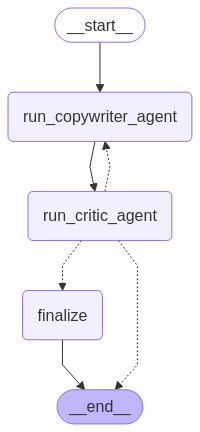

# Example Invocations

This section demonstrates how to run the compiled LangGraph workflow.
1.  `product_details`: A dictionary is created containing the initial inputs required by the workflow (as defined in `AdCopyWorkflowState`). Note that "guaranteed results" in the first example's objective is a forbidden term, so we expect the workflow to go through at least one revision cycle.
2.  `advertising_copy_workflow.invoke(input=product_details)`: This is the command to execute the entire workflow. The `input` dictionary populates the initial state of the graph. LangGraph then orchestrates the execution of nodes according to the defined edges and conditions.
3.  `print(response['final_ad_copy'])`: After the workflow completes (reaches an `END` state), the `invoke` method returns the final state of the `AdCopyWorkflowState`. We then print the `final_ad_copy` from this state.

**Example 1**

In [ ]:
product_details = {
    "product_name": "Quantum Widget",
    "target_audience": "Tech enthusiasts looking for performance boosts",
    "key_objective": "Drive pre-orders for the new guaranteed results widget"
}

In [ ]:
response = advertising_copy_workflow.invoke(input=product_details)

--- Running Ad Copywriter Node ---
Copywriter is generating initial draft.
--- Tool: Fetching features for product: Quantum Widget ---
Copywriter Generated/Revised Draft: '🚀 Unleash the Power of Performance with the Quantum Widget! 🚀

Tech enthusiasts, are you ready to el...'
--- Running Compliance Critic Node ---
--- Tool: Checking compliance for ad copy: '🚀 Unleash the Power of Performance with the Quantu...' ---
Critic Agent Raw Output Text: The ad copy for the Quantum Widget has been reviewed against compliance guidelines, and it has been found to be compliant with basic checks. 

Here are some additional observations regarding clarity and ethical marketing practices:

1. **Clarity**: The message is clear and effectively communicates the benefits of the Quantum Widget. The use of bullet points or sections could enhance readability, but overall, the structure is good.

2. **Potential Misleading Claims**: The claim of "50% faster processing speed" should be backed by specific compari

In [ ]:
print(response['final_ad_copy'])

🚀 Unleash the Power of Performance with the Quantum Widget! 🚀

Tech enthusiasts, are you ready to elevate your experience? Our Quantum Widget delivers a staggering **50% faster processing** speed, ensuring you stay ahead of the game. Crafted from **eco-friendly materials**, it’s not just powerful, but also sustainable. Plus, with **AI-powered optimization**, you’ll enjoy seamless efficiency like never before.

🔒 Pre-order now and secure your **3-year warranty** for peace of mind. Don’t miss out on the future of technology—boost your performance today!


**Example 2**

In [ ]:
product_details = {
    "product_name": "Stellar Service Plan",
    "target_audience": "Existing customers seeking premium support",
    "key_objective": "Increase upgrades to the premium plan"
}

In [ ]:
response = advertising_copy_workflow.invoke(input=product_details)

--- Running Ad Copywriter Node ---
Copywriter is generating initial draft.
--- Tool: Fetching features for product: Stellar Service Plan ---
Copywriter Generated/Revised Draft: 'Upgrade to the Stellar Service Plan and experience unparalleled support! 🌟 Enjoy 24/7 Priority Suppo...'
--- Running Compliance Critic Node ---
--- Tool: Checking compliance for ad copy: 'Upgrade to the Stellar Service Plan and experience...' ---
Critic Agent Raw Output Text: The ad copy has been reviewed against compliance guidelines, and it has been found to be compliant with basic checks. 

In terms of clarity and ethical marketing practices, the copy effectively communicates the benefits of the Stellar Service Plan without making misleading claims. The use of phrases like "unparalleled support" and "exclusive discounted upgrades" is acceptable as long as they are substantiated by the actual service offerings.

Overall, the ad copy is clear, engaging, and aligns well with ethical marketing standards. 

APPRO

In [ ]:
print(response['final_ad_copy'])

Upgrade to the Stellar Service Plan and experience unparalleled support! 🌟 Enjoy 24/7 Priority Support, a Dedicated Account Manager, and Monthly Performance Reports tailored just for you. Plus, take advantage of exclusive discounted upgrades. Elevate your service experience today!


**Example 3**

In [ ]:
product_details = {
    "product_name": "Flexi Datasuit",
    "target_audience": "Data Scientists/Engineers looking for effective platform",
    "key_objective": "Boost your scalabiliy and efficiency in secure environments"
}

response = advertising_copy_workflow.invoke(input=product_details)

--- Running Ad Copywriter Node ---
Copywriter is generating initial draft.
--- Tool: Fetching features for product: Flexi Datasuit ---
Copywriter Generated/Revised Draft: 'Unlock the power of data with Flexi Datasuit! 🚀 

Designed for Data Scientists and Engineers, our pl...'
--- Running Compliance Critic Node ---
--- Tool: Checking compliance for ad copy: 'Unlock the power of data with Flexi Datasuit! 🚀 

...' ---
Critic Agent Raw Output Text: The ad copy for Flexi Datasuit has been reviewed, and the compliance check indicates that it is compliant with basic guidelines. Here are some additional observations:

1. **Clarity**: The message is clear and effectively communicates the benefits of the product. The use of terms like "real-time analytics," "scalable storage," and "secure data encryption" is appropriate for the target audience of Data Scientists and Engineers.

2. **Misleading Claims**: There are no misleading claims present in the ad copy. The benefits mentioned are realistic a

In [ ]:
print(response['final_ad_copy'])

Unlock the power of data with Flexi Datasuit! 🚀 

Designed for Data Scientists and Engineers, our platform offers real-time analytics and scalable storage options to enhance your efficiency. With top-notch secure data encryption and seamless integration with popular CRMs, you can boost your scalability while ensuring your data remains protected. 

Transform your data experience today!
